# Completion Trie and metrics

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pyquickhelper.ipythonhelper import add_notebook_menu
add_notebook_menu()

## Wikipedia titles, uniform

In [ ]:
from mlstatpy.data.wikipedia import download_titles
file_titles = download_titles(country='fr')

In [ ]:
from mlstatpy.data.wikipedia import enumerate_titles
list_titles = list(sorted(set(_ for _ in enumerate_titles(file_titles) if 'A' <= _[0] <= 'Z')))

In [ ]:
len(list_titles), list_titles[:5], list_titles[1000000:1000005]

(3049881,
 ['A',
  'A & A',
  'A (Airport Express)',
  'A (Ayumi Hamasaki)',
  "A (Disque d'Ayumi Hamasaki)"],
 ["Festival d'Angouleme 1982",
  "Festival d'Angouleme 1983",
  "Festival d'Angouleme 1984",
  "Festival d'Angouleme 1985",
  "Festival d'Angouleme 1986"])

In [ ]:
from mlstatpy.nlp.completion import CompletionTrieNode

def gain_dynamique_moyen_par_mot(queries, weights):
    per = list(zip(weights, queries))
    total = sum(w * len(q) for q, w in zip(queries, weights))
    res = []
    trie = CompletionTrieNode.build([(None, q) for _, q in per])
    trie.precompute_stat()
    trie.update_stat_dynamic()
    wks = [(w, p, len(w)-trie.min_keystroke0(w)[0]) for p, w in per]
    wks_dyn = [(w, p, len(w)-trie.min_dynamic_keystroke(w)[0]) for p, w in per]
    wks_dyn2 = [(w, p, len(w)-trie.min_dynamic_keystroke2(w)[0]) for p, w in per]
    gain = sum( g*p/total for w, p, g in wks)
    gain_dyn = sum( g*p/total for w, p, g in wks_dyn)
    gain_dyn2 = sum( g*p/total for w, p, g in wks_dyn2)
    ave_length = sum( len(w) * p / total for p, w in per)
    return gain, gain_dyn, gain_dyn2, ave_length

In [ ]:
import time, random, pandas

def benchmark(sizes):
    print("time", 0)
    allres = []
    for size in sizes:
        begin = time.clock()
        if size is None:
            size = len(list_titles)
            spl = list_titles
        else:
            spl = random.sample(list_titles, size)
        spl.sort()
        res = gain_dynamique_moyen_par_mot(spl, [1.0] * len(spl))
        dt = time.clock() - begin
        print("time: {0}s - nb={1}".format(dt, len(spl)), "gain", tuple(_/res[-1] for _ in res))
        allres.append((size, dt) + res)
        # with open("sample%d.txt" % len(spl), "w", encoding="utf-8") as f:
        #    f.write("\n".join(spl))
    df = pandas.DataFrame(allres, columns="size time mks mks' mks\" ave_len".split())    
    for c in "mks mks' mks\"".split():
        df["%" + c] = df[c] / df["ave_len"]
        df[c + "/mks"] = df[c] / df["mks"]    
    return df
                  
df = benchmark([200, 500, 800, 1000, 2000, 5000, 8000, 10000, 20000])
df.tail(n=2)

time 0
time: 0.31166905144536405s - nb=200 gain (0.8354461238420288, 0.8354461238420288, 0.8354461238420288, 1.0)
time: 0.9024564218398405s - nb=500 gain (0.8055443548387085, 0.8055443548387085, 0.8055443548387085, 1.0)
time: 1.5836877716017759s - nb=800 gain (0.7821086261980841, 0.7821086261980841, 0.7821086261980841, 1.0)
time: 2.7268322241902943s - nb=1000 gain (0.7823231563643664, 0.7823231563643664, 0.7823231563643664, 1.0)
time: 6.331294083838727s - nb=2000 gain (0.7516497007519553, 0.7516497007519553, 0.7516497007519553, 1.0)
time: 9.343264447012155s - nb=5000 gain (0.7134059155159743, 0.7134059155159743, 0.7134059155159743, 1.0)
time: 10.017527909608194s - nb=8000 gain (0.696262736277684, 0.696262736277684, 0.696262736277684, 1.0)
time: 13.270264988398257s - nb=10000 gain (0.6848716689498281, 0.6854764920261547, 0.6854764920261547, 1.0)
time: 25.76545794165517s - nb=20000 gain (0.6558279242488682, 0.6558999310792304, 0.6558999310792304, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
7,10000,13.270265,0.684872,0.685476,0.685476,1.0,0.684872,1.0,0.685476,1.000883,0.685476,1.000883
8,20000,25.765458,0.655828,0.655900,0.655900,1.0,0.655828,1.0,0.655900,1.000110,0.655900,1.000110


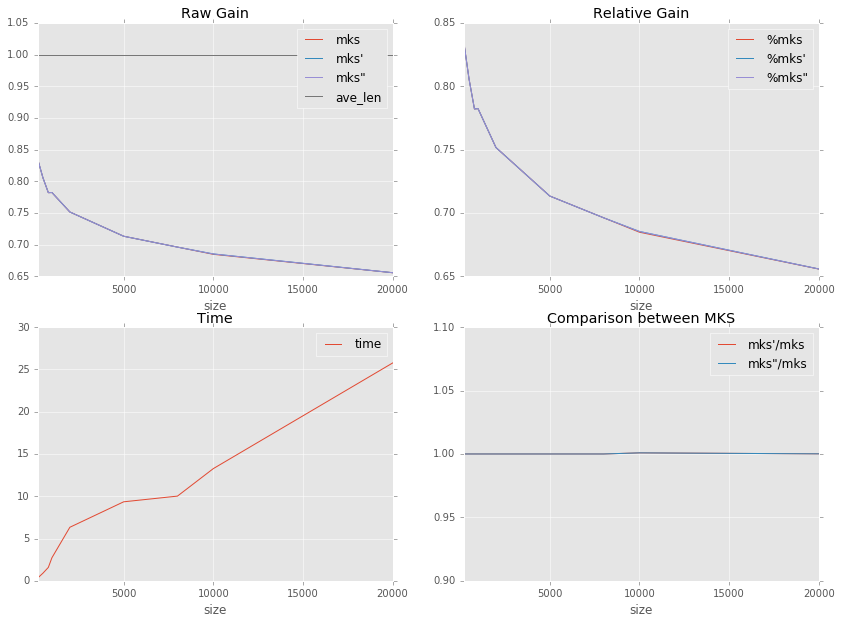

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(2, 2, figsize=(14,10))
df.plot(x="size", y="time", ax=ax[1,0])
df.plot(x="size", y=["mks", "mks'", "mks\"", "ave_len"], ax=ax[0,0])
df.plot(x="size", y=["%mks", "%mks'", "%mks\""], ax=ax[0,1])
df.plot(x="size", y=["mks'/mks", "mks\"/mks"], ax=ax[1,1])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[1,1].set_ylim([0.9, 1.1])
ax[0,0].set_title("Raw Gain")
ax[0,1].set_title("Relative Gain")
ax[1,0].set_title("Time")
ax[1,1].set_title("Comparison between MKS")

## Reduce the alphabet size

In [ ]:
from mlstatpy.data.wikipedia import enumerate_titles
list_titles = list(sorted(set(_ for _ in enumerate_titles(file_titles) if 'A' <= _[0] <= 'Z')))

In [ ]:
import time, random, pandas

def char_modulo(c, size):
    if len(c) != 1:
        raise Exception("unexpected size '%s'" % c)
    if len(c) != len(c.lower()):
        raise Exception("unexpected lower size '%s' != '%s' (%d != %d)" % (c, c.lower(), len(c), len(c.lower())))
    if size is None:
        return c
    else:
        o = ord(c.lower())
        a = 97
        d = (o - a) + size * 10
        return chr(97  + (d % size))

def reduce_alphabet(sample, size):
    return ["".join(char_modulo(c, size) for c in word) for word in sample]

def benchmark_size(size, alphabet_sizes):
    if size is None:
        size = len(list_titles)
        sample = list_titles
    else:
        sample = random.sample(list_titles, size)
    print("time", 0)
    allres = []
    for size in alphabet_sizes:
        begin = time.clock()
        spl = reduce_alphabet(sample, size)
        spl = list(sorted(set(spl)))
        res = gain_dynamique_moyen_par_mot(spl, [1.0] * len(spl))
        dt = time.clock() - begin
        print("time: {0}s - nb={1}".format(dt, len(spl)), "gain", tuple(_/res[-1] for _ in res))
        if size is None:
            size = max(_ for _ in alphabet_sizes if _ is not None) + 5
        allres.append((size, dt) + res)
        # with open("sample%d.txt" % len(spl), "w", encoding="utf-8") as f:
        #    f.write("\n".join(spl))
    df = pandas.DataFrame(allres, columns="size time mks mks' mks\" ave_len".split())    
    for c in "mks mks' mks\"".split():
        df["%" + c] = df[c] / df["ave_len"]
        df[c + "/mks"] = df[c] / df["mks"]    
    return df
                  
df = benchmark_size(5000, [None] + list(range(2, 26)))
df.tail(n=2)

time 0
time: 7.013119846461876s - nb=5000 gain (0.7152392342052291, 0.7152392342052291, 0.7152392342052291, 1.0)
time: 4.501136654233889s - nb=4604 gain (0.41493211237591726, 0.4341748515123153, 0.4341748515123153, 1.0)
time: 5.464762435844037s - nb=4950 gain (0.5576603727166503, 0.5638518154048028, 0.5638518154048028, 1.0)
time: 5.951072979359765s - nb=4968 gain (0.5967492497874808, 0.6017472526347043, 0.6017472526347043, 1.0)
time: 5.937005493401159s - nb=4989 gain (0.6375821072663631, 0.6387996480386318, 0.6387996480386318, 1.0)
time: 6.077082091409579s - nb=4991 gain (0.6479257865237499, 0.6492247269156822, 0.6492247269156822, 1.0)
time: 5.845930752184586s - nb=4997 gain (0.664240143955507, 0.6645059708817298, 0.6645059708817298, 1.0)
time: 6.41310068840707s - nb=4996 gain (0.6703166375282466, 0.6706029097526839, 0.6706029097526839, 1.0)
time: 6.5039740134670865s - nb=4999 gain (0.6831651793472137, 0.6835229537857631, 0.6835229537857631, 1.0)
time: 6.617815194903272s - nb=4999 gain

,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
23,24,8.256776,0.711386,0.711703,0.711703,1.0,0.711386,1.0,0.711703,1.000445,0.711703,1.000445
24,25,7.602205,0.712285,0.712602,0.712602,1.0,0.712285,1.0,0.712602,1.000445,0.712602,1.000445


In [ ]:
df = df.sort_values("size")

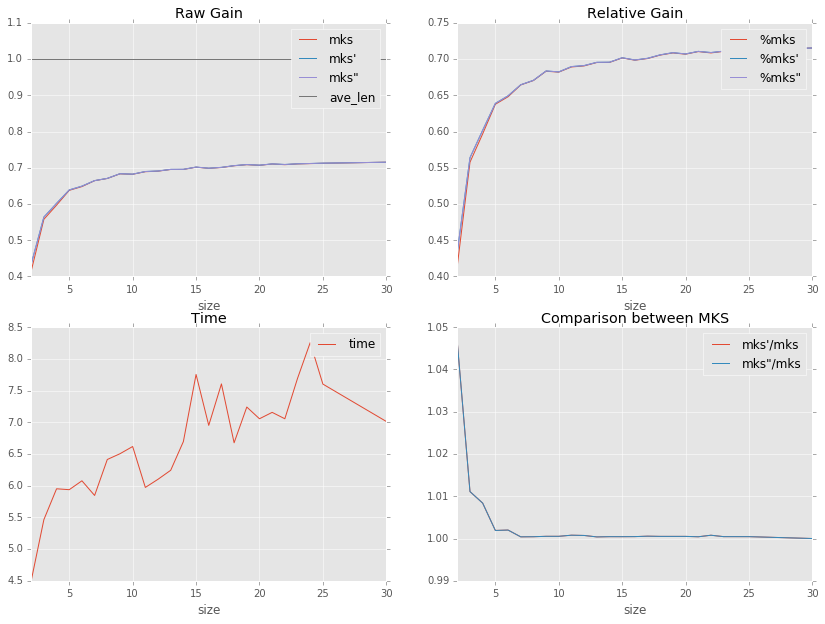

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(2, 2, figsize=(14,10))
df.plot(x="size", y="time", ax=ax[1,0])
df.plot(x="size", y=["mks", "mks'", "mks\"", "ave_len"], ax=ax[0,0])
df.plot(x="size", y=["%mks", "%mks'", "%mks\""], ax=ax[0,1])
df.plot(x="size", y=["mks'/mks", "mks\"/mks"], ax=ax[1,1])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
#ax[1,1].set_ylim([0.9, 1.1])
ax[0,0].set_title("Raw Gain")
ax[0,1].set_title("Relative Gain")
ax[1,0].set_title("Time")
ax[1,1].set_title("Comparison between MKS")

## Wikipedia titles, uniform, longer test

In [ ]:
df2 = benchmark([50000])
df2.tail(n=2)

time 0
time: 68.63595889913026s - nb=50000 gain (0.6158621330531338, 0.6160970035628945, 0.6160970035628945, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
0,50000,68.635959,0.615862,0.616097,0.616097,1.0,0.615862,1.0,0.616097,1.000381,0.616097,1.000381


In [ ]:
df2 = benchmark([50000, 100000, 200000, 500000, 500000, 1000000, 2000000, None])
df2.tail(n=2)

time 0
time: 58.25727343248201s - nb=50000 gain (0.6146985870531279, 0.6148011677790299, 0.6148011677790299, 1.0)
time: 114.99605805916929s - nb=100000 gain (0.5840461093334263, 0.5845461208250078, 0.5845461208250078, 1.0)
time: 233.06796405469964s - nb=200000 gain (0.5492333375455491, 0.5506825642444365, 0.5506825642444365, 1.0)
time: 801.7003624635547s - nb=500000 gain (0.504068249490837, 0.5076079454720062, 0.5076079454720062, 1.0)
time: 1280.7007789801928s - nb=500000 gain (0.5043474701035779, 0.5075275398109061, 0.5075275398109061, 1.0)


KeyboardInterrupt: 

In [ ]:
dfall = pandas.concat([df, df2])
f, ax = plt.subplots(2, 2, figsize=(14,10))
dfall.plot(x="size", y="time", ax=ax[1,0])
dfall.plot(x="size", y=["mks", "mks'", "mks\"", "ave_len"], ax=ax[0,0])
dfall.plot(x="size", y=["%mks", "%mks'", "%mks\""], ax=ax[0,1])
dfall.plot(x="size", y=["mks'/mks", "mks\"/mks"], ax=ax[1,1])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[1,1].set_ylim([0.9, 1.1])
ax[0,0].set_title("Raw Gain")
ax[0,1].set_title("Relative Gain")
ax[1,0].set_title("Time")
ax[1,1].set_title("Comparison between MKS")